In [8]:
import torchvision.models as models
import torch
import json
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from PIL import Image
from torchvision import transforms
import csv

In [9]:
network = models.resnet50(pretrained=True)

In [421]:

images = []
with open('mapping.txt', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        input_image = Image.open("data/" + row[0])
        row.append(input_image)
        images.append(row)
print(images)

[['bullet_train_1.jpg', 'bullet_train', '466', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x7F92FA8EF730>], ['car_wheel_1.jpg', 'car_wheel', '479', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=844x569 at 0x7F92F59BFFD0>], ['electric_locomotive_1.jpg', 'electric_locomotive', '547', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x325 at 0x7F92EA606EE0>], ['guacamole_1.jpg', 'guacamole', '924', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x628 at 0x7F92E9980820>], ['power_drill_1.jpg', 'power_drill', '740', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=702x395 at 0x7F92E9980910>], ['red_wine_1.jpg', 'red_wine', '966', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x640 at 0x7F92E9980340>], ['rifle_1.jpg', 'rifle', '764', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=900x525 at 0x7F92E99808B0>], ['samoyed_1.jpg', 'samoyed', '258', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=729x486 at 0x7F92E

In [244]:
with open('imagenet1000_clsid_to_human.json') as json_file:
    class_idx = json.load(json_file)
    labels = {int(key): value for key, value in class_idx.items()}

<Figure size 432x288 with 0 Axes>

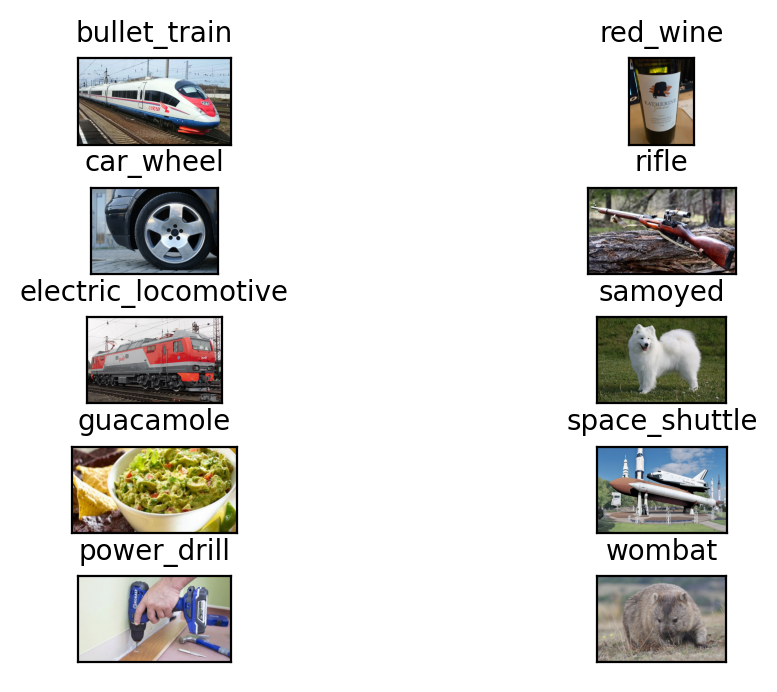

In [245]:
plt.figure()
f, axarr = plt.subplots(5,2, dpi=200) 
for i in range(10):
    y = i // 5
    x = i % 5
    input_image = Image.open("data/" + images[i][0])
    axarr[x, y].axes.get_xaxis().set_visible(False)
    axarr[x, y].axes.get_yaxis().set_visible(False)
    axarr[x, y].imshow(images[i][3])
    axarr[x, y].set_title(images[i][1], fontsize=10)
    plt.subplots_adjust(wspace=None, hspace=0.5)

In [388]:
def transform_image(image):
    centre_crop = transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    input_tensor = centre_crop(image)
    input_batch = input_tensor.unsqueeze(0)
    return input_batch

def inverse_transform(image):
    inv = transforms.Compose([ 
        transforms.Normalize([ 0., 0., 0. ],[ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize([ -0.485, -0.456, -0.406 ],[ 1., 1., 1. ]),])
    return inv(image)

def predict(image, network, raw_image=True):
    #use raw image, it will transform it
    #return: array of probability for each class
    input_batch = image
    if raw_image:
        input_batch = transform_image(image)
    with torch.no_grad():
        network.eval()
        prediction = network(input_batch)  
    return prediction.data.numpy()

def probabilty_of_class(image, class_index, network, raw_image=True):
    prediction = predict(image, network, raw_image)
    return prediction[0,class_index]

def get_most_probable_class(image, network, raw_image=True):
    #returns index and class name
    prediction = predict(image, network, raw_image)
    index = prediction.argmax()
    return(index, labels[index])

/usr/lib/python3.9/site-packages/torchvision/transforms/transforms.py:207: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


<Figure size 432x288 with 0 Axes>

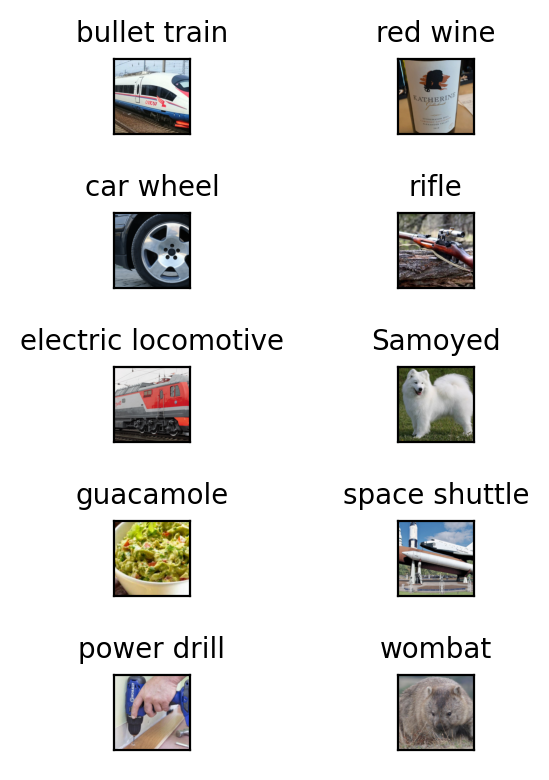

In [422]:
plt.figure()
f, axarr = plt.subplots(5,2, dpi=200) 
to_image = transforms.ToPILImage()
for i in range(10):
    y = i // 5
    x = i % 5
    input_image = transform_image(images[i][3])
    axarr[x, y].imshow(inverse_transform(input_image[0]).permute(1, 2, 0).detach().numpy() )
    axarr[x, y].axes.get_xaxis().set_visible(False)
    axarr[x, y].axes.get_yaxis().set_visible(False)
    index, label = get_most_probable_class(input_image, network, False)
    axarr[x, y].set_title(label.split(",")[0], fontsize=10)
    plt.tight_layout()

In [423]:
for i in images:
    i[3] = transform_image(i[3])

In [368]:

get_most_probable_class(images[0][3], network, False)

(466, 'bullet train, bullet')

In [390]:
def fast_gradient_attack(image, correct_prediction_index, epsilon, network_to_attack, iteration_count = 1):
    #return image, probability before and probabilty 
    changed_image = image
    prev_prob = probabilty_of_class(changed_image, correct_prediction_index, network_to_attack, False)
    if iteration_count == -1:
        iteration_count = 100
    for i in tqdm(range(iteration_count)):
        predict_index = get_most_probable_class(changed_image, network, False)[0]
        if predict_index != correct_prediction_index:
            break
        network.eval()
        image.requires_grad = True
        prediction = network_to_attack(image)

        loss = F.nll_loss(prediction, torch.tensor([correct_prediction_index]))

        network.zero_grad()
        loss.backward()

        data_grad = image.grad.data


        changed_image = changed_image + epsilon * data_grad.sign()

        changed_image = changed_image.clamp(-3, 3)
        new_prob = probabilty_of_class(changed_image, correct_prediction_index, network_to_attack, False)
    return (changed_image, prev_prob, new_prob)

In [386]:
res, prev, new = fast_gradient_attack(images[0][3], 466, 0.35, network)

100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


In [378]:
get_most_probable_class(res, network, False)

(565, 'freight car')

In [286]:
print(images[0][3][0].min())

tensor(-2.0323, grad_fn=<MinBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


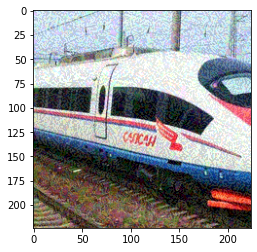

In [379]:
plt.imshow(inverse_transform(res[0]).permute(1, 2, 0).detach().numpy())

In [354]:
from tqdm import tqdm

def simba_attack(image, correct_prediction_index, epsilon, network_to_attack, iteration_count = 1000):
    result = image
    result.requires_grad = False
    size = result.shape[1] * result.shape[2] * result.shape[3]
    perm = torch.randperm(size)
    prev_prob = probabilty_of_class(result, correct_prediction_index, network_to_attack, False)
    start_prob = prev_prob
    if iteration_count == -1:
        iteration_count = 25000
    for i in tqdm(range(iteration_count)):
        predict_index = get_most_probable_class(result, network, False)[0]
        if predict_index != correct_prediction_index:
            break
        to_add = torch.zeros(size)
        to_add[perm[i]] = epsilon
        to_add = to_add.view(result[0].size()).clamp(-3, 3)
        result[0] += to_add
        new_prob = probabilty_of_class(result, correct_prediction_index, network_to_attack, False)
        if(new_prob < prev_prob):
            prev_prob = new_prob
        else:
            changed_image = result
            changed_image[0] -= 2*to_add
            new_prob = probabilty_of_class(result, correct_prediction_index, network_to_attack, False)
            if(new_prob < prev_prob):
                prev_prob = new_prob
            else:
                result[0] += to_add
    return (result, start_prob, prev_prob) 
    

In [355]:
res, prev, new = simba_attack(res, 466, 0.3, network, 1500)

  0%|          | 0/1500 [00:00<?, ?it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(705, 'passenger car, coach, carriage') 14.18751 14.18751


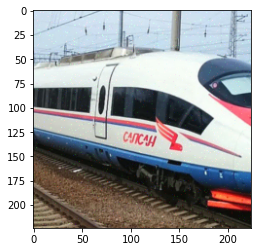

In [356]:
print(get_most_probable_class(res, network, False), prev, new)
plt.imshow(inverse_transform(res[0]).permute(1, 2, 0).detach().numpy())

In [391]:
attacks_algorithms_name = ['fast gradient attack', 'simba']
attacks_algorithms = [fast_gradient_attack, simba_attack]
result = []
for i in range(len(images)):
    result.append([])
    for j in range(len(attacks_algorithms)):
        res, prev, new = attacks_algorithms[j](images[i][3], int(images[i][2]), 0.3, network, -1)
        result[i].append((attacks_algorithms_name[j], res, prev, new))

 18%|█▊        | 4419/25000 [13:53<1:04:42,  5.30it/s]


In [393]:
import pickle
with open('result.pkl', 'wb') as f:
    pickle.dump(result, f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

10
2


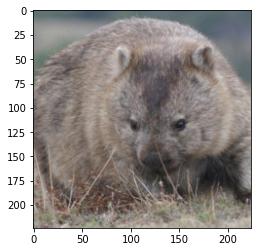

In [419]:
print(len(result))
print(len(result[0]))

for i in result:
    for j in i:
        plt.imshow(inverse_transform(j[1][0]).permute(1, 2, 0).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

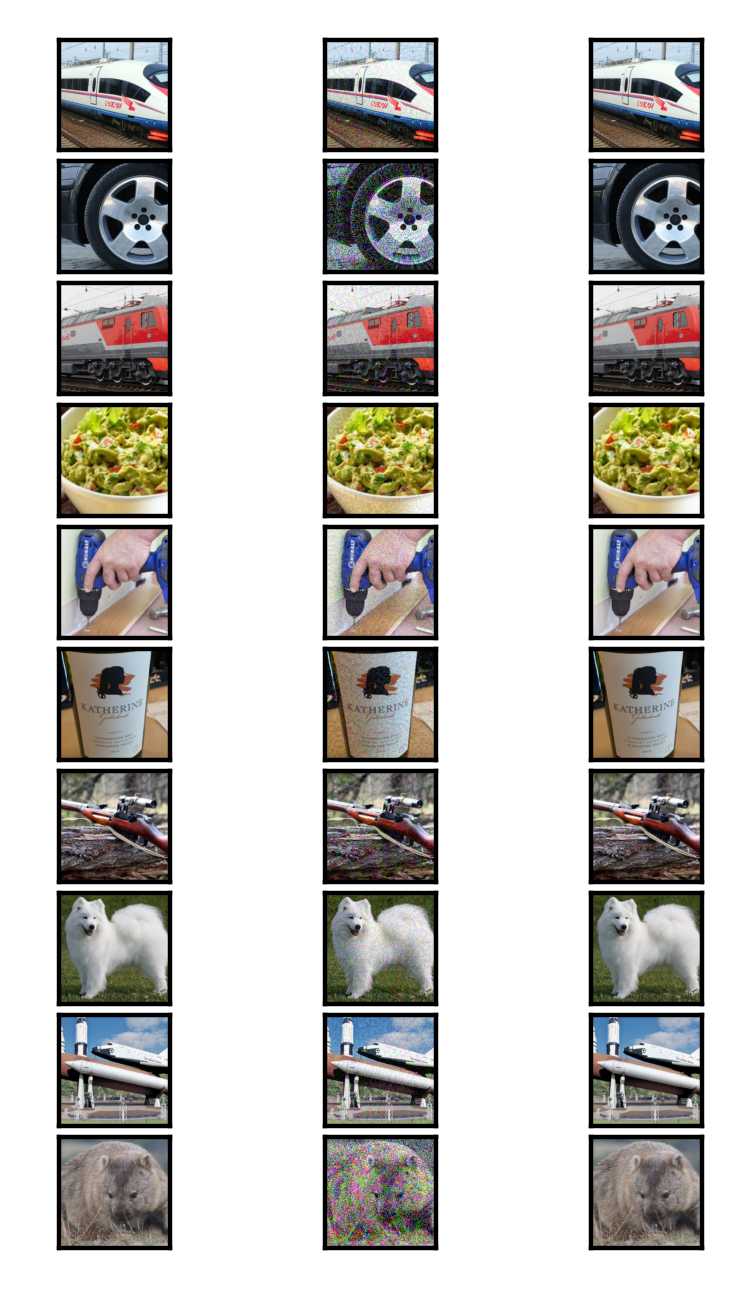

In [420]:
plt.figure()
f, axarr = plt.subplots(10,3, dpi=400) 
to_image = transforms.ToPILImage()
for i in range(10):
    axarr[i, 0].imshow(inverse_transform(images[i][3][0]).permute(1, 2, 0).detach().numpy() )
    axarr[i, 0].axes.get_xaxis().set_visible(False)
    axarr[i, 0].axes.get_yaxis().set_visible(False)
    for j in range(len(attacks_algorithms)):
        axarr[i, j+1].imshow(inverse_transform(result[i][j][1][0]).permute(1, 2, 0).detach().numpy() )
        axarr[i, j+1].axes.get_xaxis().set_visible(False)
        axarr[i, j+1].axes.get_yaxis().set_visible(False)
        #plt.tight_layout()
plt.subplots_adjust(wspace=-0.8, hspace=0.1)